#  This document is the exploratory data analysis for problems of anomaly with some of Sysmex's analyzers

## Part 1: Exploratory Data Analysis

This part is to explore data, transform and understand the data provided by Sysmex

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split 
import findspark
findspark.init()
import pyspark
# to make this notebook's output stable across runs
from IPython.display import display, HTML


rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
qc_data = pd.read_csv('~/downloads/Specific QC Lot Number Results.csv', header =None)
qc_data.columns =['Prod_ID', 'QC_Lot', 'QC_Time', 'W-X', 'W-Y', 'W-Z']

machine_data = pd.read_excel('~/downloads/Reference Set A Result Set.xlsx')
machine_data.columns=['Prod_ID', 'Upgrade_Date', 'IPU_Ver', 'Ser_No', 'Model_ID']

test_flagging = pd.read_csv('~/documents/Sysmex Analyzer Analytics/Data/Test Flagging Query Data Set.csv', header = None)
x_bar_m = pd.read_csv('~/documents/Sysmex Analyzer Analytics/Data/XBarM Result Set for Steve (CSV Form Revised).csv', header = None)
test_flagging.columns = ['Prod_ID', 'Count_Date', 'IPU_Ver', 'Count_Val', 'Counter']
x_bar_m.columns = ['Prod_ID', 'X_Bar_Run_Date_Time', 'X_Bar_M_X','X_Bar_M_Y', 'X_Bar_M_Z']


## Clean up data and create a joined dataset
In this step, we clean out records where W-X, W-Y, W-Z are all zeros. Also, we temporarily remove historical of software upgrade for each product ID just to keep one record for one machine with the latest software version then merge with QC data to create consolidated machine_qc dataset for analysis purpose

In [3]:

print('number of products in machine data: {:32,d}'.format(len(np.unique(machine_data['Prod_ID']))))
print('number of records in machine data:  {:32,d}'.format( len((machine_data['Prod_ID']))))
print('number of products in QC data:      {:32,d}'.format( len(np.unique(qc_data['Prod_ID']))))
print('number of records in QC data:       {:32,d}'.format( len((qc_data['Prod_ID']))))

print('number of records in QC data with zero W-X data {:20,d}'.format( np.sum((qc_data['W-X']==0))))
print('number of records in QC data with zero W-Y data {:20,d}'.format(  np.sum((qc_data['W-Y']==0))))
print('number of records in QC data with zero W-Z data {:20,d}'.format(  np.sum((qc_data['W-Z']==0))))

print('number of records in QC data with zero W-Z, W-Y, W-Z data {:10,d}'.format(np.sum((qc_data['W-X']==0)&(qc_data['W-Y']==0)&(qc_data['W-Z']==0))))

number of products in machine data:                            3,378
number of records in machine data:                             3,470
number of products in QC data:                                 3,807
number of records in QC data:                              2,435,412
number of records in QC data with zero W-X data               18,127
number of records in QC data with zero W-Y data               18,078
number of records in QC data with zero W-Z data               18,090
number of records in QC data with zero W-Z, W-Y, W-Z data     18,071


In [4]:


test_flagging['Prod_ID'] = test_flagging.Prod_ID.astype(str)

test_flagging['Count_Date'] = pd.to_datetime(test_flagging.Count_Date)


x_bar_m['Prod_ID'] = x_bar_m.Prod_ID.astype(str)
x_bar_m['X_Bar_Run_Date_Time'] = pd.to_datetime(x_bar_m.X_Bar_Run_Date_Time)




In [5]:
clean_qc_data = qc_data[((qc_data['W-X']!=0)&(qc_data['W-Y']!=0)&(qc_data['W-Z']!=0))]
machine_data = machine_data.sort_values(by =['Prod_ID', 'Upgrade_Date'], ascending = [True, True])
clean_qc_data['Prod_ID'] = clean_qc_data['Prod_ID'].astype(str)

clean_qc_data['QC_Time'] = pd.to_datetime(clean_qc_data['QC_Time'])

machine_data['Prod_ID'] = machine_data['Prod_ID'].astype(str)

machine_data['Upgrade_Date'] = pd.to_datetime(machine_data['Upgrade_Date'])


unique_machine_data=machine_data.drop_duplicates(subset='Prod_ID', keep ='first')
qc_machine_data = pd.merge(clean_qc_data, unique_machine_data, how ='left')
x_bar_machine_data = pd.merge(x_bar_m, unique_machine_data, how ='left')
x_bar_machine_data.dropna()
x_bar_machine_data =x_bar_machine_data.sort_values(by =['Prod_ID', 'X_Bar_Run_Date_Time'], ascending = [True, True])

qc_machine_data=qc_machine_data.dropna()
qc_machine_data = qc_machine_data.sort_values(['QC_Lot', 'Prod_ID','QC_Time'], ascending = [True, True, True])


print('number of records for clean QC data:       {:32,d}'.format(len(clean_qc_data['Prod_ID'])))
print('number of records for unique machine data: {:32,d}'.format(len(unique_machine_data['Prod_ID'])))
print('number of records in consol data set       {:32,d}'.format(len(qc_machine_data['Prod_ID'])))

/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


number of records for clean QC data:                              2,417,282
number of records for unique machine data:                            3,378
number of records in consol data set                              2,200,636


In [ ]:
## Function to return a list of products that has more than one IPU versions
# def get_multi_IPU():
#     multi_ipu_machine = pd.DataFrame(columns = machine_data.columns)
#     Unique_Prod_ID = np.unique(machine_data.Prod_ID)
#     for prod_id in Unique_Prod_ID:
#         k = machine_data[machine_data.Prod_ID ==prod_id]
#         if k.shape[0]>1:
#             multi_ipu_machine = multi_ipu_machine.append(k)
#     multi_ipu_machine.sort_values(['Prod_ID', 'Upgrade_Date'], ascending = [False, False])
#     return multi_ipu_machine

def get_IPU_Ver(prod_id, tran_date):
    machine_mini_list = machine_data[machine_data['Prod_ID'] == prod_id]
    t = machine_mini_list.shape[0]
    if t ==0: return None
    k=0
#     print(machine_mini_list.shape)
#     print('hello')
    for i in range(t):
#         print('before print date')
#         print('date is', machine_mini_list.values[i,1])
        if machine_mini_list.Upgrade_Date.iloc[i] < tran_date: k=i
    
    return machine_mini_list.IPU_Ver.iloc[k]

#get_IPU_Ver('125862',pd.to_datetime('2017-01-19'))
qc_machine_data.head()


IPU_Ver =[]
for i in range(qc_machine_data.shape[0]):
    prod_id = qc_machine_data['Prod_ID'].iloc[i]
    tran_date = qc_machine_data.QC_Time.iloc[i] 
    IPU_Ver.append(get_IPU_Ver(prod_id, tran_date))

qc_machine_data['IPU_Ver'] = IPU_Ver




IPU_Ver =[]
for i in range(test_flagging.shape[0]):
    prod_id = test_flagging['Prod_ID'].iloc[i]
    tran_date = test_flagging.Count_Date.iloc[i] 
    IPU_Ver.append(get_IPU_Ver(prod_id, tran_date))

test_flagging['IPU_Ver'] = IPU_Ver




IPU_Ver =[]
for i in range(x_bar_m.shape[0]):
    prod_id = x_bar_m['Prod_ID'].iloc[i]
    tran_date = x_bar_m.X_Bar_Run_Date_Time.iloc[i] 
    IPU_Ver.append(get_IPU_Ver(prod_id, tran_date))

x_bar_m['IPU_Ver'] = IPU_Ver
    
# print(prod_id)

In [ ]:
x_bar_machine_data['IPU_Ver'] = x_bar_m['IPU_Ver']

In [91]:
IPU_Ver =[]
for i in range(x_bar_machine_data.shape[0]):
    prod_id = x_bar_machine_data['Prod_ID'].iloc[i]
    tran_date = x_bar_machine_data.X_Bar_Run_Date_Time.iloc[i] 
    IPU_Ver.append(get_IPU_Ver(prod_id, tran_date))

x_bar_machine_data['IPU_Ver'] = IPU_Ver
    
# print(prod_id)

In [96]:


transformed_qc_machine_data = qc_machine_data[['QC_Lot', 'W-X', 'W-Y', 'W-Z', 'IPU_Ver', 'Model_ID']]
transformed_qc_machine_data = pd.get_dummies(transformed_qc_machine_data, columns =['IPU_Ver', 'Model_ID', 'QC_Lot']).values

transformed_xbar_data = x_bar_machine_data[['IPU_Ver','Model_ID', 'X_Bar_M_X','X_Bar_M_Y', 'X_Bar_M_Z']]
transformed_xbar_data = pd.get_dummies(transformed_xbar_data, columns =['IPU_Ver', 'Model_ID']).values

In [60]:
test_flagging[test_flagging.Prod_ID =='142382']

,Prod_ID,Count_Date,IPU_Ver,Count_Val,Counter
2649364,142382,2017-01-01,00-15 (Build 5),10,PLTAbnSctIPCounter
2649365,142382,2017-01-01,00-15 (Build 5),3818,PLTAbnDistribIPCounter
2649366,142382,2017-01-01,00-15 (Build 5),4436,WBCAbnSctCounter
2649367,142382,2017-01-01,00-15 (Build 5),7251,AtypicalLymphIPCounter
2649368,142382,2017-01-01,00-15 (Build 5),8588,IGPresentIPCounter
2649369,142382,2017-01-01,00-15 (Build 5),10215,LeftShiftIPCounter
2649370,142382,2017-01-01,00-15 (Build 5),171110,DIFFCounter
2649371,142382,2017-01-01,00-15 (Build 5),188487,WBModeCounter
2649372,142382,2017-01-01,00-15 (Build 5),196633,CBCCounter
2649373,142382,2017-01-01,00-16 (Build 7),10,PLTAbnSctIPCounter


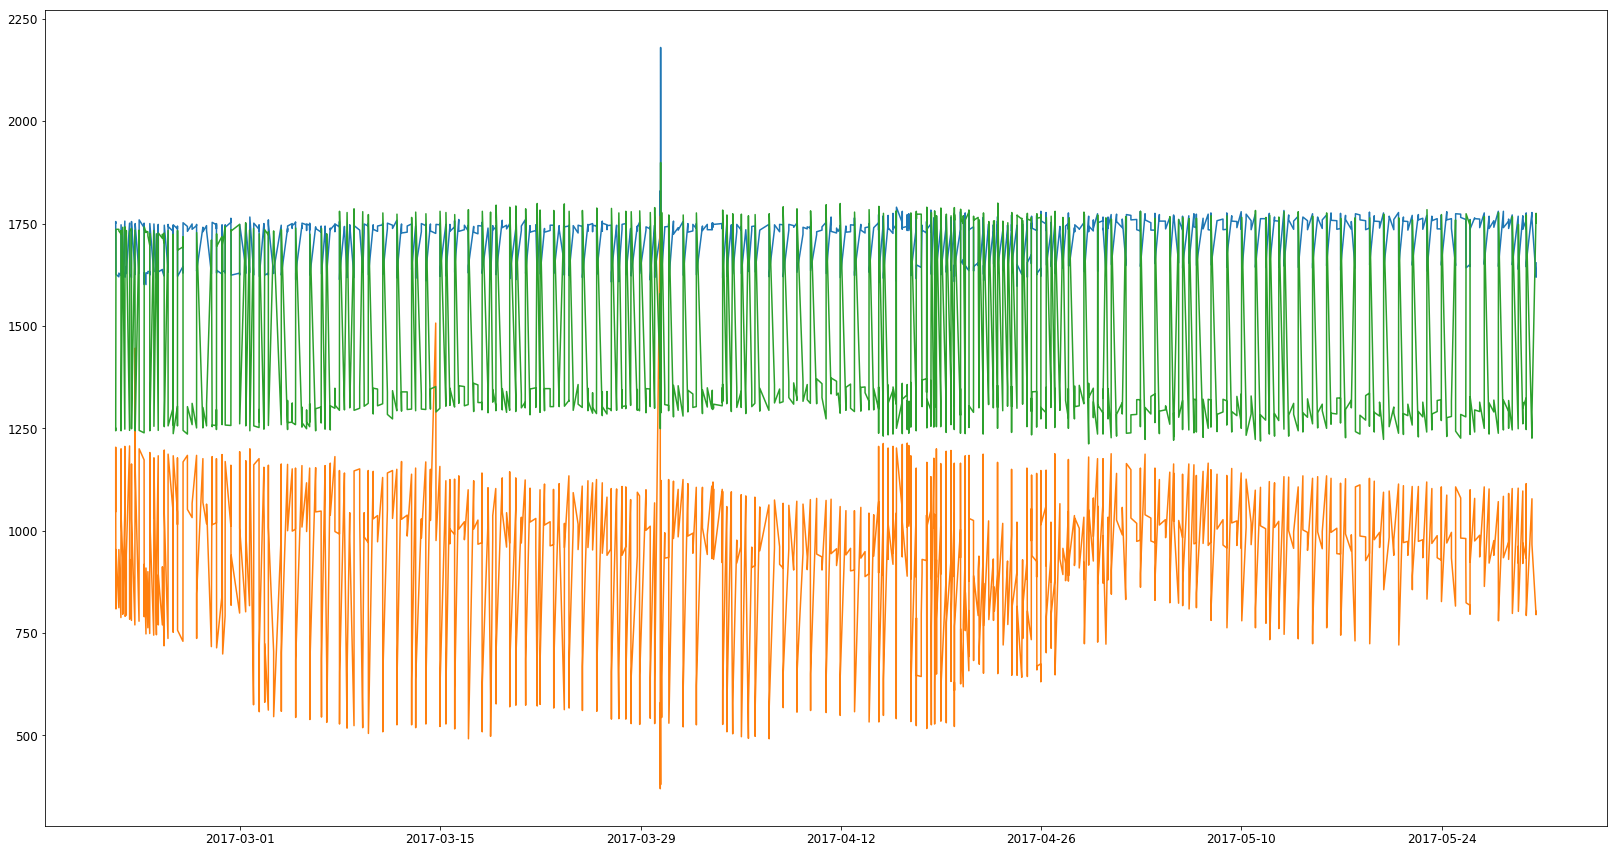

In [55]:
 t =qc_machine_data[qc_machine_data.Prod_ID =='146703'].sort_values('QC_Time')
fig, ax = plt.subplots(figsize =(28,15))


ax.plot(t.QC_Time, t['W-X'])
ax.plot(t.QC_Time, t['W-Y'])
ax.plot(t.QC_Time, t['W-Z'])




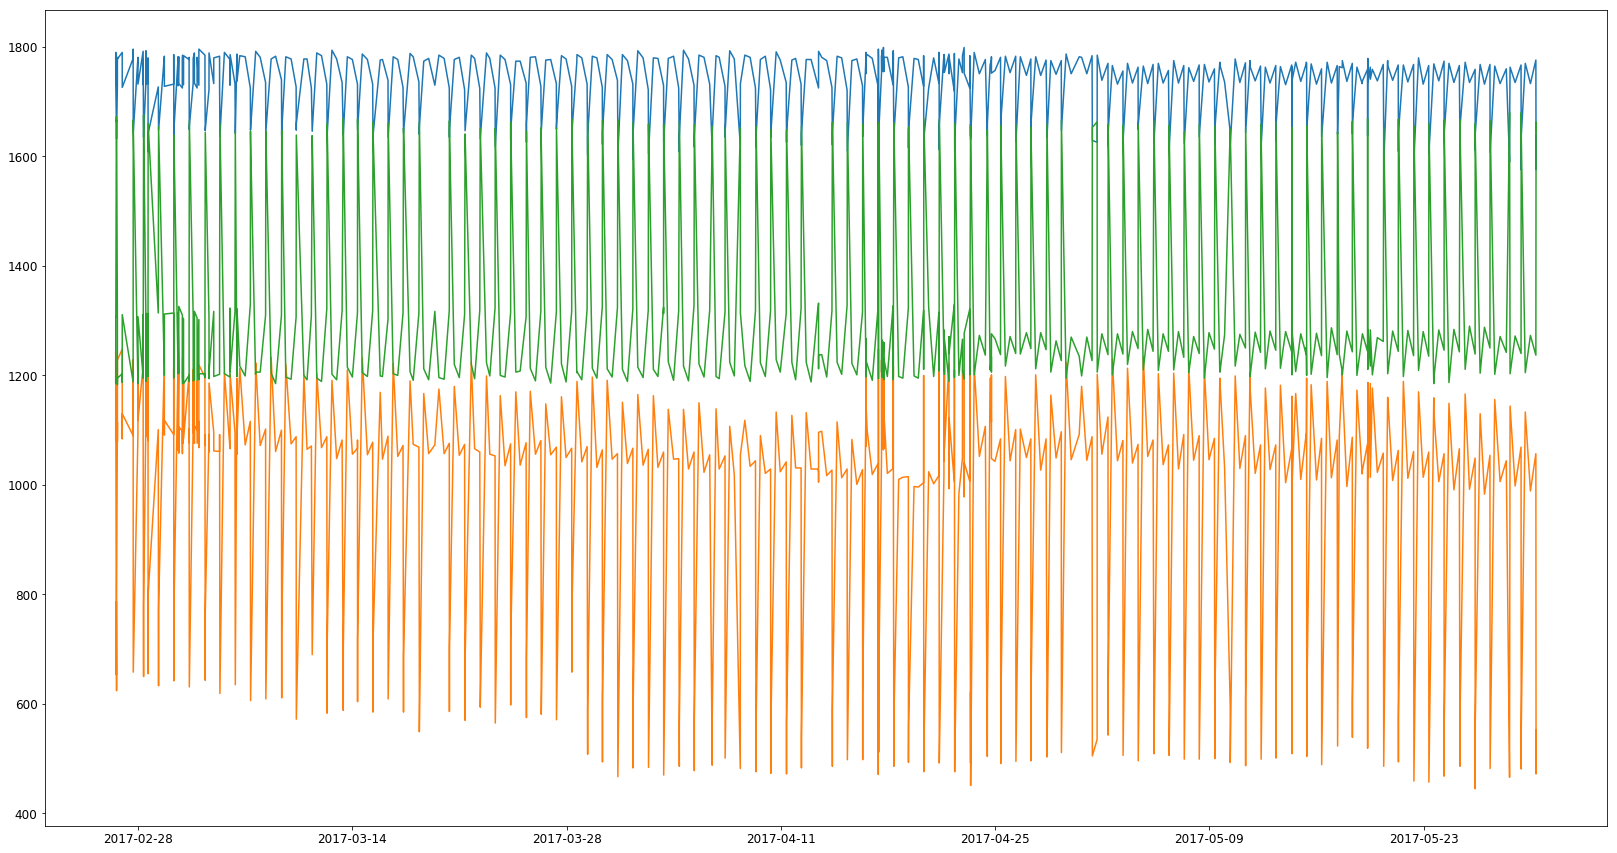

In [30]:
 t =qc_machine_data[qc_machine_data.Prod_ID =='148391'].sort_values('QC_Time')
fig, ax = plt.subplots(figsize =(28,15))


ax.plot(t.QC_Time, t['W-X'])
ax.plot(t.QC_Time, t['W-Y'])
ax.plot(t.QC_Time, t['W-Z'])




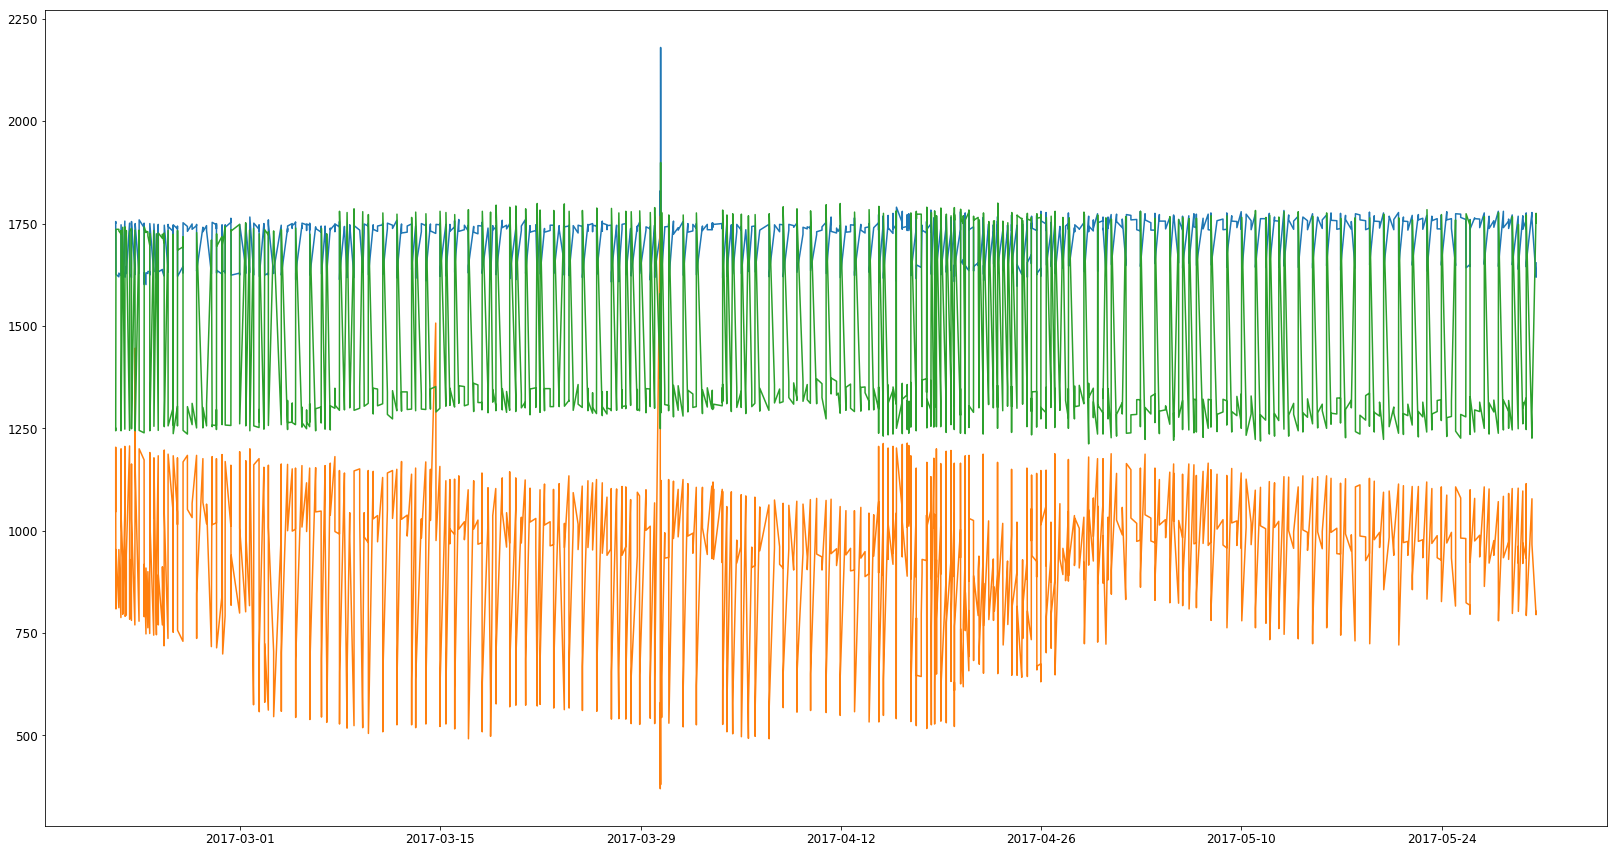

In [31]:
 t =qc_machine_data[qc_machine_data.Prod_ID =='146703'].sort_values('QC_Time')
fig, ax = plt.subplots(figsize =(28,15))


ax.plot(t.QC_Time, t['W-X'])
ax.plot(t.QC_Time, t['W-Y'])
ax.plot(t.QC_Time, t['W-Z'])




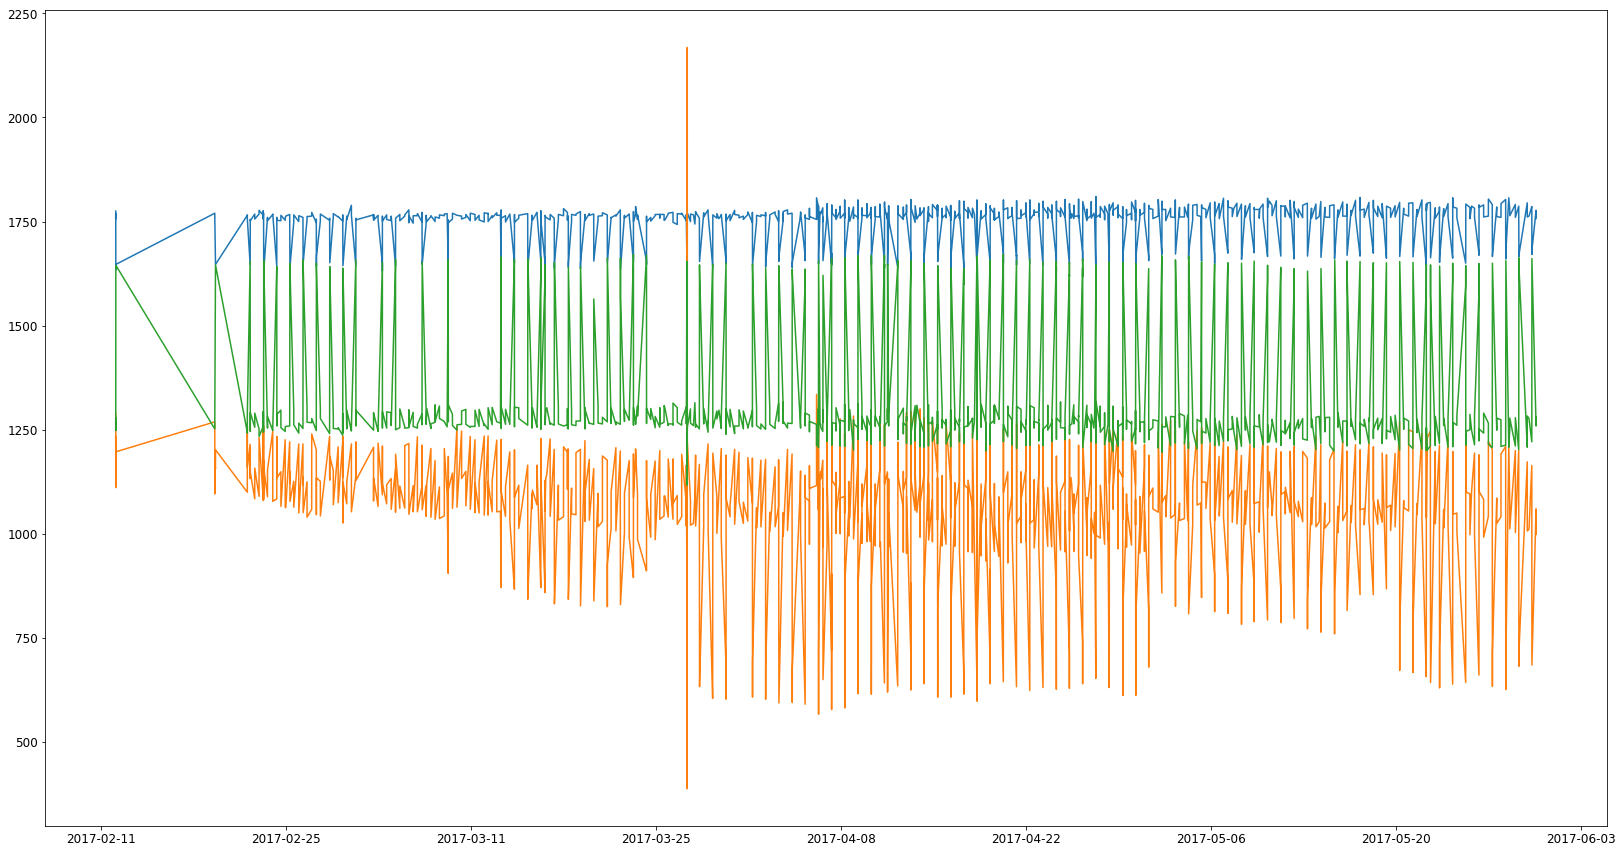

In [33]:
 t =qc_machine_data[qc_machine_data.Prod_ID =='164173'].sort_values('QC_Time')
fig, ax = plt.subplots(figsize =(28,15))


ax.plot(t.QC_Time, t['W-X'])
ax.plot(t.QC_Time, t['W-Y'])
ax.plot(t.QC_Time, t['W-Z'])




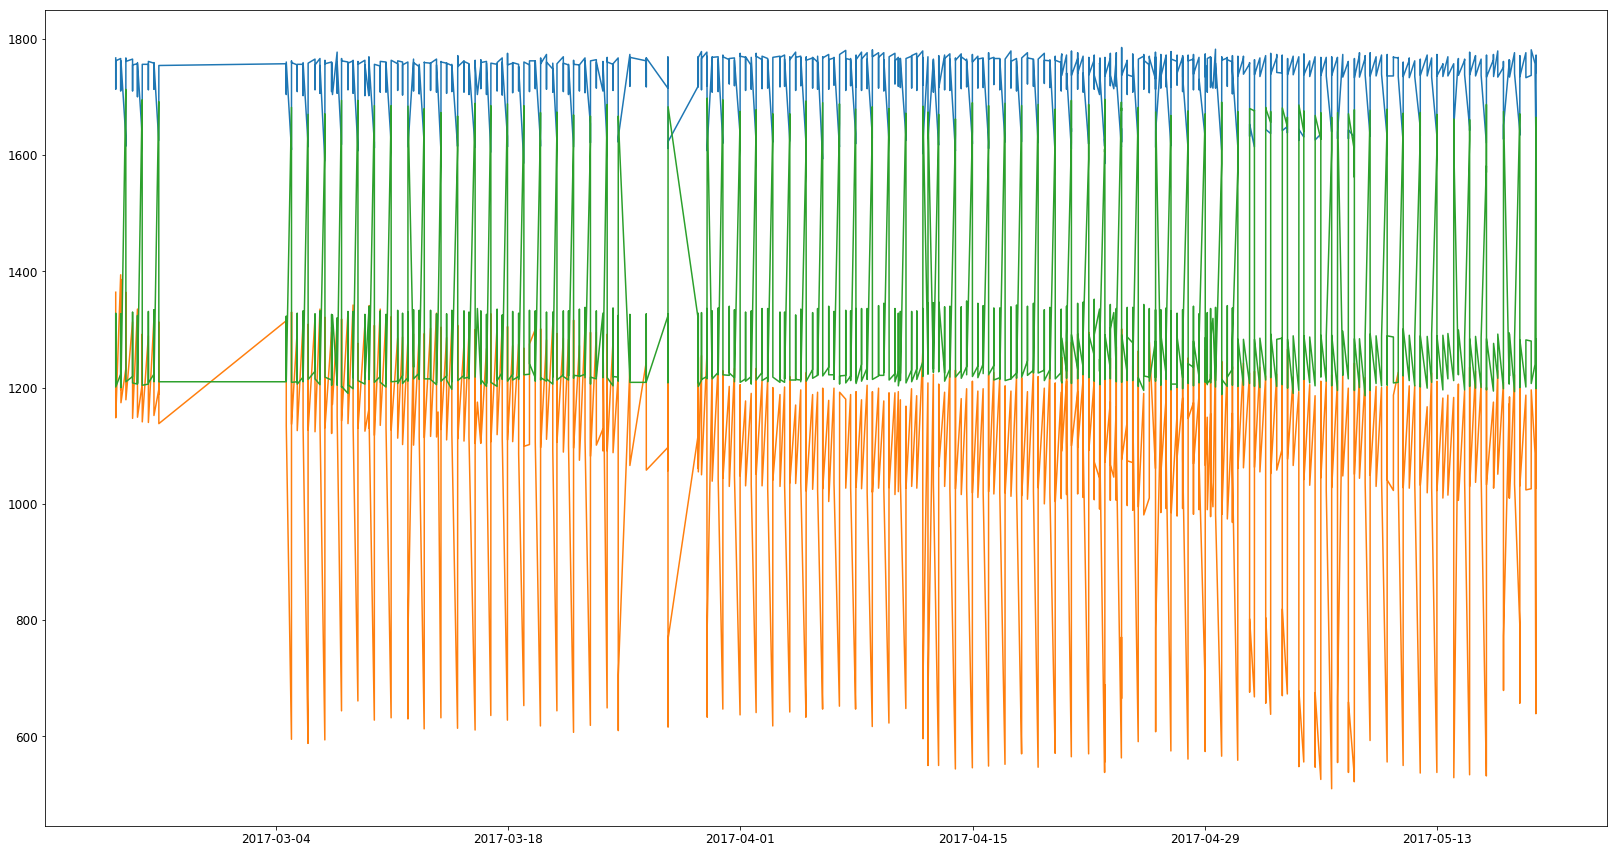

In [50]:
 t =qc_machine_data[qc_machine_data.Prod_ID =='128502'].sort_values('QC_Time')
fig, ax = plt.subplots(figsize =(28,15))


ax.plot(t.QC_Time, t['W-X'])
ax.plot(t.QC_Time, t['W-Y'])
ax.plot(t.QC_Time, t['W-Z'])



In [7]:
test_flagging[['Prod_ID','Count_Date', 'IPU_Ver', 'Counter']].describe()

,Prod_ID,Count_Date,IPU_Ver,Counter
count,4957240,4957240,4957240,4957240
unique,3681,146,17,11
top,126556,2017-05-19 00:00:00,00-16 (Build 7),CBCCounter
freq,244802,42509,3108178,973334
first,NaN,2017-01-01 00:00:00,NaN,NaN
last,NaN,2017-05-26 00:00:00,NaN,NaN


In [1]:
x=pd.to_datetime(test_flagging[(test_flagging.Prod_ID =='158238')&(test_flagging.Counter =='WBModeCounter')].Count_Date)
y =test_flagging[(test_flagging.Prod_ID =='158238')&(test_flagging.Counter =='WBModeCounter')].Count_Val
plt.plot(x,y)

NameError: name 'pd' is not defined

In [90]:
test_flagging[(test_flagging.Prod_ID =='126732')].sort_values(['Count_Date','Counter'])

,Prod_ID,Count_Date,IPU_Ver,Count_Val,Counter
826975,126732,2017-01-01,00-15 (Build 5),18696,AtypicalLymphIPCounter
826985,126732,2017-01-01,00-16 (Build 7),18696,AtypicalLymphIPCounter
826995,126732,2017-01-01,00-19 (Build 9),18696,AtypicalLymphIPCounter
826980,126732,2017-01-01,00-15 (Build 5),379231,CBCCounter
826990,126732,2017-01-01,00-16 (Build 7),379231,CBCCounter
827000,126732,2017-01-01,00-19 (Build 9),379231,CBCCounter
826978,126732,2017-01-01,00-15 (Build 5),254894,DIFFCounter
826988,126732,2017-01-01,00-16 (Build 7),254894,DIFFCounter
826998,126732,2017-01-01,00-19 (Build 9),254894,DIFFCounter
826971,126732,2017-01-01,00-15 (Build 5),917,DimorphicPopulationIPCounter


In [ ]:
def shift_date(x):
    x =x.sort_values('Count_Date')
    values= x['max'].copy().values
    values[1:] = values[0:len(values)-1]
    x['max'] = x['max'].values - values
   
    return x

X =test_flagging[(test_flagging.Counter!='CBCCounter')&(test_flagging.Counter!='DIFFCounter')].groupby(['Prod_ID', 'Counter','Count_Date'])['Count_Val'].aggregate(['max']).reset_index().groupby(['Prod_ID', 'Counter']).apply(shift_date)



In [92]:
data_flagging_ver02[data_flagging_ver02.Prod_ID=='126732'].sort_values('Count_Date')

Counter,IPU_Ver,Prod_ID,Count_Date,AtypicalLymphIPCounter,DimorphicPopulationIPCounter,IGPresentIPCounter,LeftShiftIPCounter,PLTAbnDistribIPCounter,PLTAbnSctIPCounter,RETAbnSctIPCounter,WBCAbnSctCounter,WBModeCounter,Total_Flag
12455,00-15 (Build 5),126732,2017-01-09,0.052419,0.000000,0.032258,0.036290,0.064516,0.0,0.000000,0.042339,496.0,0.227823
500159,00-19 (Build 9),126732,2017-01-09,0.052419,0.000000,0.032258,0.036290,0.064516,0.0,0.000000,0.042339,496.0,0.227823
132606,00-16 (Build 7),126732,2017-01-09,0.052419,0.000000,0.032258,0.036290,0.064516,0.0,0.000000,0.042339,496.0,0.227823
12468,00-15 (Build 5),126732,2017-01-31,0.038123,0.000000,0.038123,0.049853,0.035191,0.0,0.000000,0.055718,341.0,0.217009
500172,00-19 (Build 9),126732,2017-01-31,0.038123,0.000000,0.038123,0.049853,0.035191,0.0,0.000000,0.055718,341.0,0.217009
132619,00-16 (Build 7),126732,2017-01-31,0.038123,0.000000,0.038123,0.049853,0.035191,0.0,0.000000,0.055718,341.0,0.217009
12472,00-15 (Build 5),126732,2017-02-19,0.046243,0.005780,0.028902,0.086705,0.092486,0.0,0.000000,0.086705,173.0,0.346821
500176,00-19 (Build 9),126732,2017-02-19,0.046243,0.005780,0.028902,0.086705,0.092486,0.0,0.000000,0.086705,173.0,0.346821
132623,00-16 (Build 7),126732,2017-02-19,0.046243,0.005780,0.028902,0.086705,0.092486,0.0,0.000000,0.086705,173.0,0.346821
12480,00-15 (Build 5),126732,2017-03-06,0.034351,0.000000,0.036260,0.049618,0.043893,0.0,0.001908,0.045802,524.0,0.211832


In [ ]:
data_flagging_ver01 = X.unstack().fillna(0)

In [65]:
data_flagging_ver01['Total_Flag'] = data_flagging_ver01.AtypicalLymphIPCounter + data_flagging_ver01.DimorphicPopulationIPCounter+ data_flagging_ver01.IGPresentIPCounter + data_flagging_ver01.LeftShiftIPCounter + data_flagging_ver01.PLTAbnDistribIPCounter+ data_flagging_ver01.RETAbnSctIPCounter + data_flagging_ver01.WBCAbnSctCounter
data_flagging_ver01 =data_flagging_ver01.reset_index(level=[0, 1, 2])


In [66]:
data_flagging_ver02 =data_flagging_ver01[data_flagging_ver01.WBModeCounter>0]

In [67]:
data_flagging_ver02['AtypicalLymphIPCounter'] = data_flagging_ver02.AtypicalLymphIPCounter/data_flagging_ver02.WBModeCounter


data_flagging_ver02['DimorphicPopulationIPCounter'] = data_flagging_ver02.DimorphicPopulationIPCounter/data_flagging_ver02.WBModeCounter
data_flagging_ver02['IGPresentIPCounter'] = data_flagging_ver02.IGPresentIPCounter/data_flagging_ver02.WBModeCounter
data_flagging_ver02['LeftShiftIPCounter'] = data_flagging_ver02.LeftShiftIPCounter/data_flagging_ver02.WBModeCounter


data_flagging_ver02['PLTAbnDistribIPCounter'] = data_flagging_ver02.PLTAbnDistribIPCounter/data_flagging_ver02.WBModeCounter
data_flagging_ver02['PLTAbnSctIPCounter'] = data_flagging_ver02.PLTAbnSctIPCounter/data_flagging_ver02.WBModeCounter


data_flagging_ver02['RETAbnSctIPCounter'] = data_flagging_ver02.RETAbnSctIPCounter/data_flagging_ver02.WBModeCounter
data_flagging_ver02['WBCAbnSctCounter'] = data_flagging_ver02.WBCAbnSctCounter/data_flagging_ver02.WBModeCounter
data_flagging_ver02['Total_Flag'] = data_flagging_ver02.AtypicalLymphIPCounter + data_flagging_ver02.DimorphicPopulationIPCounter+ data_flagging_ver02.IGPresentIPCounter + data_flagging_ver02.LeftShiftIPCounter + data_flagging_ver02.PLTAbnDistribIPCounter+ data_flagging_ver02.RETAbnSctIPCounter + data_flagging_ver02.WBCAbnSctCounter





/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [79]:
test_flagging[test_flagging.Prod_ID =='158238']

,Prod_ID,Count_Date,IPU_Ver,Count_Val,Counter
4103444,158238,2017-01-01,00-16 (Build 7),1017,RETAbnSctIPCounter
4103445,158238,2017-01-01,00-16 (Build 7),2262,PLTAbnDistribIPCounter
4103446,158238,2017-01-01,00-16 (Build 7),3376,LeftShiftIPCounter
4103447,158238,2017-01-01,00-16 (Build 7),3913,WBCAbnSctCounter
4103448,158238,2017-01-01,00-16 (Build 7),4565,AtypicalLymphIPCounter
4103449,158238,2017-01-01,00-16 (Build 7),7059,IGPresentIPCounter
4103450,158238,2017-01-01,00-16 (Build 7),12518,DIFFCounter
4103451,158238,2017-01-01,00-16 (Build 7),14764,WBModeCounter
4103452,158238,2017-01-01,00-16 (Build 7),15793,CBCCounter
4103453,158238,2017-01-02,00-16 (Build 7),129,DimorphicPopulationIPCounter


In [75]:
bar_data_label =data_flagging_ver02.groupby('IPU_Ver')['Total_Flag'].mean().sort_values()

In [78]:
bar_data =bar_data_label.values
bar_labels =bar_data_label.index

In [79]:
bar_data_label.index

Index(['00-11 (Build 004)', '00-19D (Build 9)', '00-19D (Build 12)',
       '00-19D (Build 13)', '00-18 (Build 4)', '00-15 (Build 5)',
       '00-16 (Build 7)', '00-14 (Build 016)', '00-19C (Build 1)',
       '00-17A (Build 1)', '00-19 (Build 9)'],
      dtype='object', name='IPU_Ver')

In [80]:
np.sum(qc_machine_data.isnull())

Prod_ID         0
QC_Lot          0
QC_Time         0
W-X             0
W-Y             0
W-Z             0
Upgrade_Date    0
IPU_Ver         0
Ser_No          0
Model_ID        0
dtype: int64

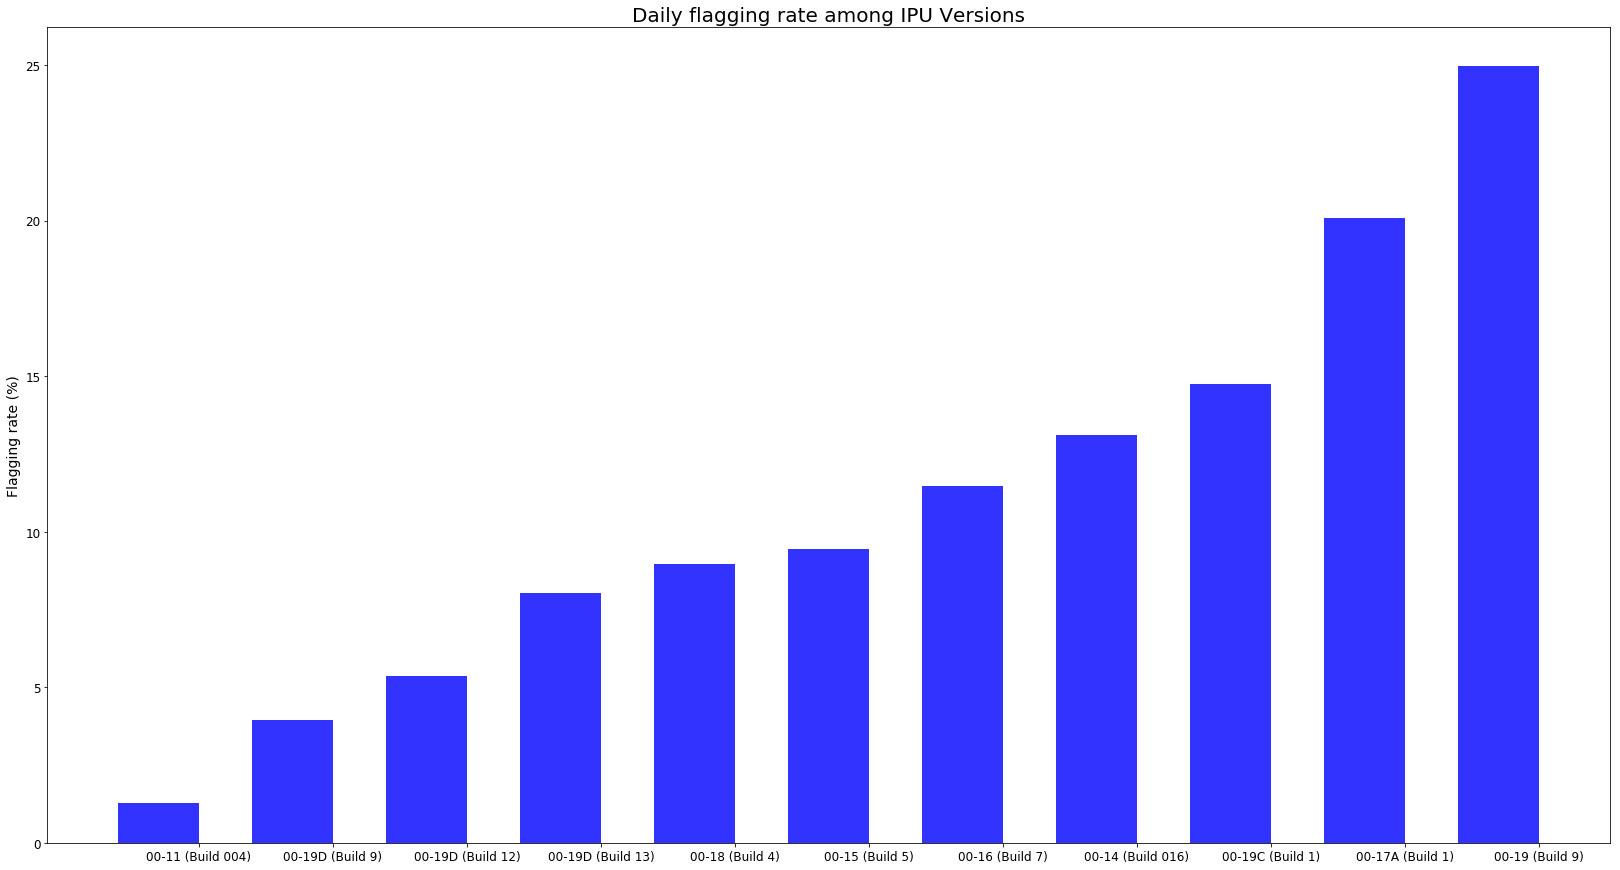

In [86]:
n_groups =len(bar_data)
index = np.arange(n_groups)
bar_width = 0.6
opacity = 0.8



fig, ax = plt.subplots(figsize =(28,15))
ax.set_ylabel('Flagging rate (%)')
ax.set_title('Daily flagging rate among IPU Versions',fontsize=20)
ax.set_xticks(index + bar_width / 2)

rects1 = ax.bar(index, 100*bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Flag rates among IPU')
ax.set_xticklabels(bar_labels)
plt.show()

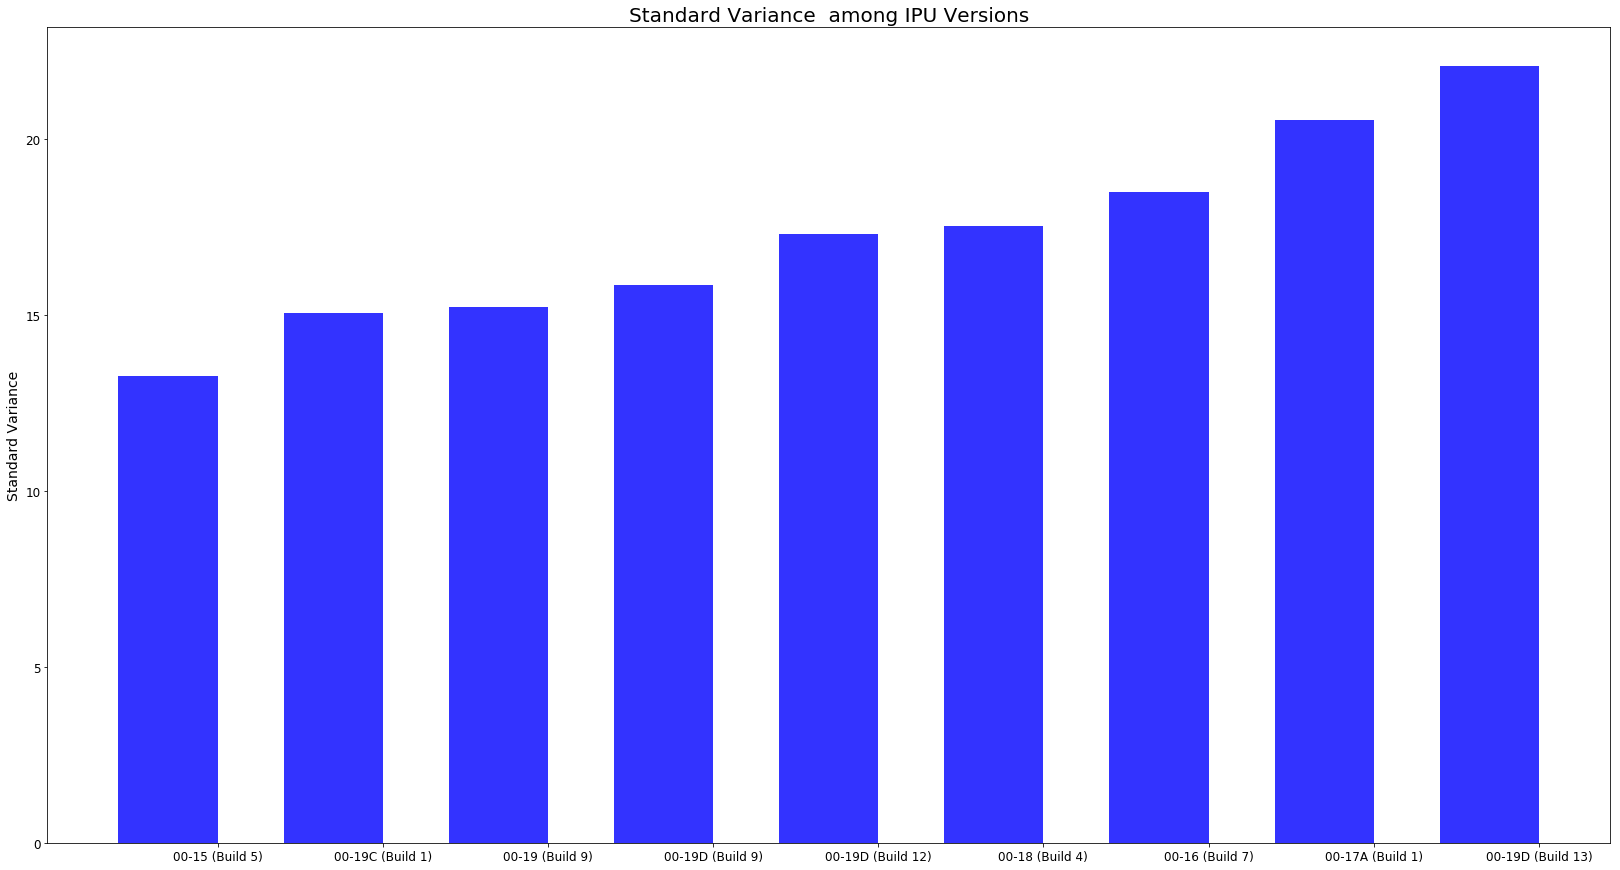

In [77]:
xbar_graph_data =x_bar_machine_data.groupby(['IPU_Ver'])['X_Bar_M_X','X_Bar_M_Y', 'X_Bar_M_Z'].aggregate(np.std).mean(axis=1).sort_values()
xbar_bar_data =xbar_graph_data.values
xbar_bar_labels =xbar_graph_data.index

xbar_n_groups =len(xbar_bar_data)
xbar_index = np.arange(xbar_n_groups)
bar_width = 0.6
opacity = 0.8



fig_xbar, ax_xbar = plt.subplots(figsize =(28,15))
ax_xbar.set_ylabel('Standard Variance')
ax_xbar.set_title('Standard Variance  among IPU Versions',fontsize=20)
ax_xbar.set_xticks(xbar_index + bar_width / 2)

rects2 = ax_xbar.bar(xbar_index, xbar_bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Standard Variance  among IPUs')
ax_xbar.set_xticklabels(xbar_bar_labels)
plt.show()

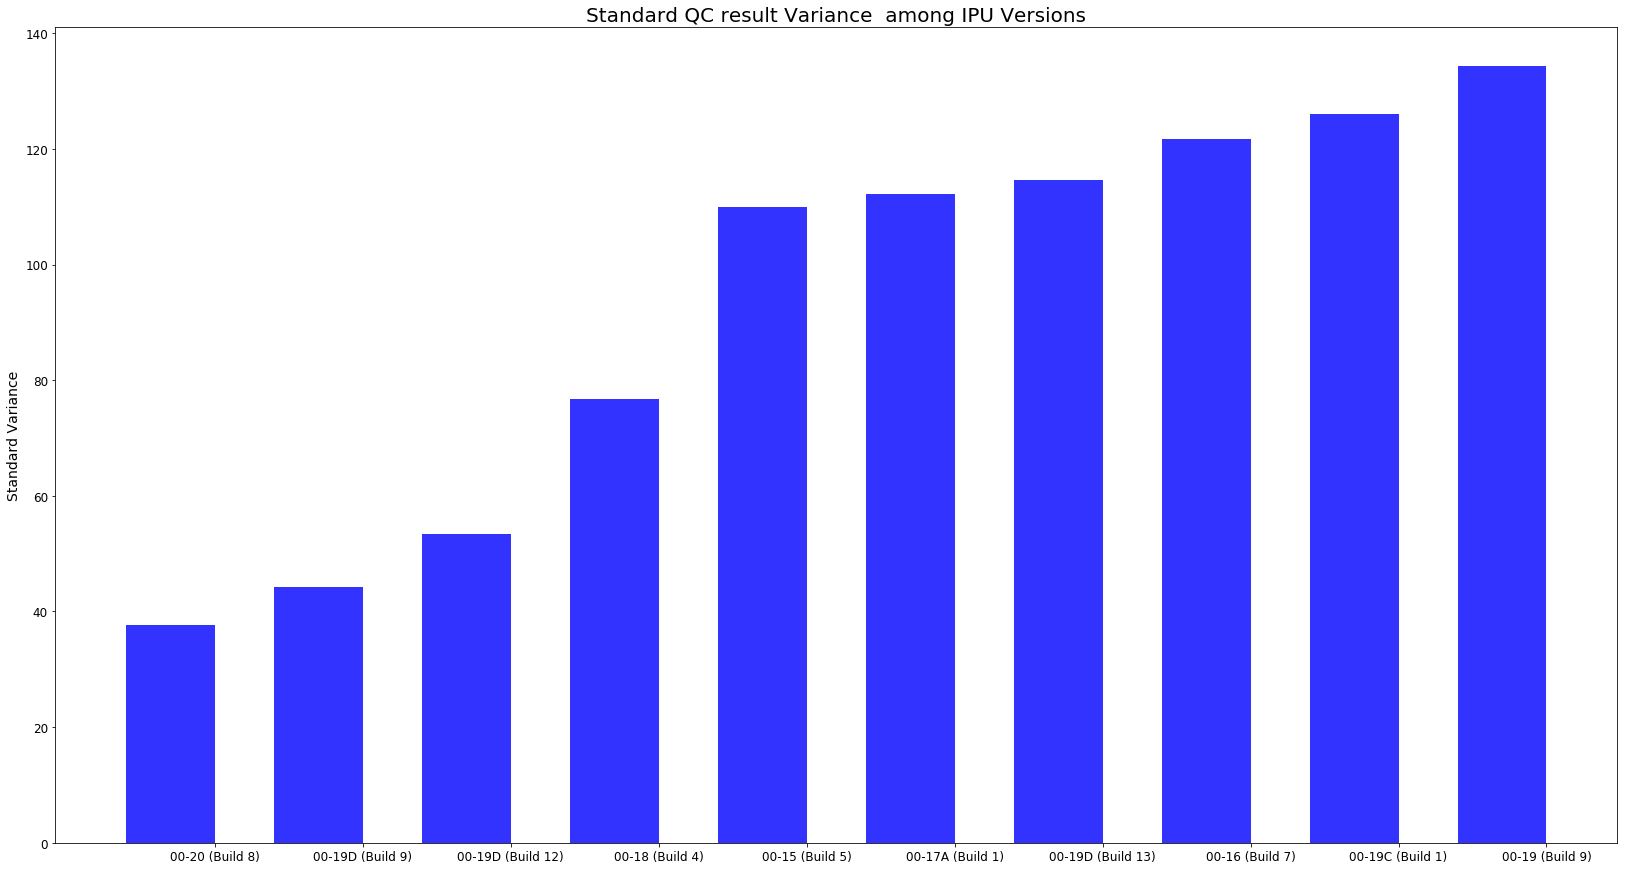

In [87]:
qc_graph_data=qc_machine_data.groupby(['IPU_Ver'])['W-X','W-Y', 'W-Z'].aggregate(np.std).mean(axis =1).sort_values()

qc_bar_data =qc_graph_data.values
qc_bar_labels =qc_graph_data.index

qc_n_groups =len(qc_bar_data)
qc_index = np.arange(qc_n_groups)
bar_width = 0.6
opacity = 0.8



fig_qc, ax_qc = plt.subplots(figsize =(28,15))
ax_qc.set_ylabel('Standard Variance')
ax_qc.set_title('Standard QC result Variance  among IPU Versions',fontsize=20)
ax_qc.set_xticks(qc_index + bar_width / 2)

rects2 = ax_qc.bar(qc_index, qc_bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Standard Variance  among IPUs')
ax_qc.set_xticklabels(qc_bar_labels)
plt.show()

## Prediction Algorithm Development

In [94]:
train_data = transformed_qc_machine_data
test_data = transformed_qc_machine_data

train_xbar_data = transformed_xbar_data
test_xbar_data = transformed_xbar_data




In [227]:
def count_unique(x):
    np_arr = x.values
    output = []
    for i in range(np_arr.shape[1]):
        output.append(len(np.unique(np_arr[:,i])))
    return  pd.DataFrame(np.array(output).reshape(-1,len(x.columns)), columns = x.columns)

qc_machine_data.groupby(['IPU_Ver', 'QC_Lot'])['Prod_ID', 'Model_ID'].apply(count_unique)

Prod_ID  Model_ID
IPU_Ver           QC_Lot                          
00-15 (Build 5)   QC-70371101 0        2         1
                  QC-70371102 0        2         1
                  QC-70371103 0        2         1
                  QC-70371301 0        3         1
                  QC-70371302 0        3         1
                  QC-70381101 0        2         1
                  QC-70381102 0        2         1
                  QC-70381103 0        2         1
                  QC-70391101 0        3         1
                  QC-70391102 0        3         1
                  QC-70391103 0        3         1
                  QC-70931101 0        2         1
                  QC-70931102 0        2         1
                  QC-70931103 0        2         1
                  QC-70931301 0        3         1
                  QC-70931302 0        3         1
                  QC-70941101 0        2         1
                  QC-70941102 0        2         1
                  QC-70941103 0        2         1
                  QC-70951101 0        3         1
                  QC-70951102 0        3         1
                  QC-70951103 0        3         1
00-16 (Build 7)   QC-70371101 0     1343         2
                  QC-70371102 0     1346         2
                  QC-70371103 0     1346         2
                  QC-70371301 0     1620         2
                  QC-70371302 0     1620         2
                  QC-70371601 0        1         1
                  QC-70381101 0     1379         1
                  QC-70381102 0     1384         1
...                                  ...       ...
00-19D (Build 13) QC-70371302 0      175         3
                  QC-70381101 0      130         3
                  QC-70381102 0      132         3
                  QC-70381103 0      132         3
                  QC-70391101 0       17         2
                  QC-70391102 0       17         2
                  QC-70391103 0       17         2
                  QC-70931101 0      235         3
                  QC-70931102 0      243         3
                  QC-70931103 0      243         3
                  QC-70931301 0      187         3
                  QC-70931302 0      189         3
                  QC-70941101 0      153         3
                  QC-70941102 0      156         3
                  QC-70941103 0      155         3
                  QC-70951101 0       15         2
                  QC-70951102 0       17         2
                  QC-70951103 0       18         2
00-19D (Build 9)  QC-70371101 0        8         1
                  QC-70371102 0        8         1
                  QC-70371103 0        8         1
                  QC-70931101 0        8         1
                  QC-70931102 0        8         1
                  QC-70931103 0        8         1
00-20 (Build 8)   QC-70391101 0        1         1
                  QC-70391102 0        1         1
                  QC-70391103 0        1         1
                  QC-70951101 0        1         1
                  QC-70951102 0        1         1
                  QC-70951103 0        1         1

[177 rows x 2 columns]

In [229]:
import random as rd
max_ind = train_data.shape[0]
def sm_next_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_ind-n_steps-1)
        ys1 = train_data[start: start+n_steps]
        ys2 = train_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 40)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 
   

max_test_ind = test_data.shape[0]

def sm_test_random_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_test_ind-n_steps-1)
        ys1 = test_data[start: start+n_steps]
        ys2 = test_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 40)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 

def format_test_data(test_data, n_steps):
    X = []
    Y = []
    max_test_range = test_data.shape[0]

    for start in range(max_test_range//n_steps):
        
        ys1 = test_data[start*n_steps: start*n_steps+n_steps]
        ys2 = test_data[start*n_steps+1: start*n_steps+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
        
    X = np.array(X).reshape(-1, n_steps, 40)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    return X, Y 
   

In [95]:
import random as rd
max_xbar_ind = train_xbar_data.shape[0]
def sm_xbar_next_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_xbar_ind-n_steps-1)
        ys1 = train_xbar_data[start: start+n_steps]
        ys2 = train_xbar_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 16)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 
   

max__xbar_test_ind = test_xbar_data.shape[0]

def sm_xbar_test_random_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_test_ind-n_steps-1)
        ys1 = test_xbar_data[start: start+n_steps]
        ys2 = test_xbar_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 40)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 

def format_xbar_test_data(test_data, n_steps):
    X = []
    Y = []
    max_xbar_test_range = test_xbar_data.shape[0]

    for start in range(max_xbar_test_range//n_steps):
        
        ys1 = test_xbar_data[start*n_steps: start*n_steps+n_steps]
        ys2 = test_xbar_data[start*n_steps+1: start*n_steps+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
        
    X = np.array(X).reshape(-1, n_steps, 16)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    return X, Y 
   

In [230]:
tf.reset_default_graph()

n_steps = 120
n_inputs = 40
n_neurons = 100
n_outputs = 3
learning_rate = 0.001



X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [96]:
tf.reset_default_graph()

n_steps = 120
n_inputs = 16
n_neurons = 100
n_outputs = 3
learning_rate = 0.001



X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [245]:
n_iterations = 10000
sm_batch_size = 50
sm_n_steps = 120
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = sm_next_batch(sm_batch_size, sm_n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")


0 	MSE: 4.27399e+10
100 	MSE: 2.62336e+08
200 	MSE: 1.33389e+08
300 	MSE: 4.40978e+07
400 	MSE: 1.25051e+07
500 	MSE: 1.4004e+07
600 	MSE: 1.0505e+07
700 	MSE: 1.44577e+07
800 	MSE: 1.01413e+07
900 	MSE: 1.37374e+07
1000 	MSE: 1.58143e+07
1100 	MSE: 9.37588e+06
1200 	MSE: 1.28982e+07
1300 	MSE: 1.07968e+07
1400 	MSE: 8.35836e+06
1500 	MSE: 1.11293e+07
1600 	MSE: 1.01738e+07
1700 	MSE: 9.79109e+06
1800 	MSE: 9.56375e+06
1900 	MSE: 1.15524e+07
2000 	MSE: 1.10924e+07
2100 	MSE: 1.04805e+07
2200 	MSE: 1.17996e+07
2300 	MSE: 1.09967e+07
2400 	MSE: 7.05574e+06
2500 	MSE: 1.32758e+07
2600 	MSE: 1.13571e+07
2700 	MSE: 1.07608e+07
2800 	MSE: 6.00713e+06
2900 	MSE: 8.39139e+06


In [97]:
n_iterations = 10000
sm_batch_size = 50
sm_n_steps = 120
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = sm_xbar_next_batch(sm_batch_size, sm_n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    save_path = saver.save(sess, "/tmp/my_xbar_model_final.ckpt")



0 	MSE: 1.1451e+10
100 	MSE: 5.82161e+07
200 	MSE: 1.6668e+07
300 	MSE: 3.71196e+06
400 	MSE: 1.37026e+07
500 	MSE: 1.79458e+06
600 	MSE: 1.17297e+06
700 	MSE: 651947.0
800 	MSE: 1.51643e+06
900 	MSE: 691725.0
1000 	MSE: 544313.0
1100 	MSE: 735682.0
1200 	MSE: 445797.0
1300 	MSE: 886555.0
1400 	MSE: 970483.0
1500 	MSE: 299835.0
1600 	MSE: 584924.0
1700 	MSE: 305746.0
1800 	MSE: 447802.0
1900 	MSE: 376432.0
2000 	MSE: 356799.0
2100 	MSE: 445953.0
2200 	MSE: 518855.0
2300 	MSE: 332692.0
2400 	MSE: 335919.0
2500 	MSE: 523186.0
2600 	MSE: 589002.0
2700 	MSE: 370020.0
2800 	MSE: 424282.0
2900 	MSE: 614345.0
3000 	MSE: 245262.0
3100 	MSE: 353075.0
3200 	MSE: 490532.0
3300 	MSE: 656178.0
3400 	MSE: 390537.0
3500 	MSE: 772137.0
3600 	MSE: 521067.0
3700 	MSE: 722693.0
3800 	MSE: 271032.0
3900 	MSE: 465323.0
4000 	MSE: 360571.0
4100 	MSE: 386148.0
4200 	MSE: 316125.0
4300 	MSE: 655512.0
4400 	MSE: 538405.0
4500 	MSE: 482469.0
4600 	MSE: 315850.0
4700 	MSE: 443656.0
4800 	MSE: 670005.0
4900 	MSE:

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,"/tmp/my_model_final.ckpt")
    X_test, Y_test = format_test_data(test_data, sm_n_steps)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    mse = loss.eval(feed_dict={X: X_test, y: Y_test})





In [98]:
with tf.Session() as sess:
    saver.restore(sess,"/tmp/my_xbar_model_final.ckpt")
    X_xbar_test, Y_xbar_test = format_xbar_test_data(test_xbar_data, sm_n_steps)
    y_xbar_pred = sess.run(outputs, feed_dict={X: X_xbar_test})
    mse = loss.eval(feed_dict={X: X_xbar_test, y: Y_xbar_test})




INFO:tensorflow:Restoring parameters from /tmp/my_xbar_model_final.ckpt


In [233]:
actual = Y_test.reshape(-1,3)
pred = y_pred.reshape(-1,3)
var = 1/3*(abs(actual[:,0]-pred[:,0])+abs(actual[:,1]-pred[:,1])+abs(actual[:,2]-pred[:,2]))


x=np.argwhere(var>np.percentile(var,99.995)).reshape(-1)

actual[x,:]

In [99]:
actual_xbar = Y_xbar_test.reshape(-1,3)
pred_xbar = y_xbar_pred.reshape(-1,3)
var = 1/3*(abs(actual_xbar[:,0]-pred_xbar[:,0])+abs(actual_xbar[:,1]-pred_xbar[:,1])+abs(actual_xbar[:,2]-pred_xbar[:,2]))


x_xbar=np.argwhere(var>np.percentile(var,99.995)).reshape(-1)

actual_xbar[x_xbar,:]

array([[1333,  516,  893],
       [1585,  446,  827],
       [1499,  456,  852],
       [1626,  510,  997],
       [1425,  449,  805],
       [1483,  406,  787],
       [1469,  433,  803],
       [1427,  504,  713],
       [1558,  522,  927],
       [1587,  511,  902],
       [1571,  530,  980],
       [1574,  527,  958],
       [1505,  507, 1004],
       [1494,  456,  753],
       [1411,  466,  818],
       [1590,  524,  944],
       [1616,  506,  960],
       [1533,  490,  953],
       [1438,  549,  771],
       [1446,  446,  772],
       [1414,  447,  831],
       [1418,  445,  822],
       [1402,  504,  719],
       [1439,  441,  761],
       [1599,  535,  938],
       [1434,  466,  795],
       [1327,  505,  632],
       [1535,  486,  848],
       [1337,  445,  685],
       [1559,  511,  869],
       [1597,  536,  957],
       [1487,  551,  957],
       [1403,  449,  800],
       [1404,  446,  789],
       [1603,  535,  876],
       [1420,  466,  915],
       [1555,  533,  982],
 

In [ ]:
machines = qc_machine_data.iloc[x+1]
HTML(machines.to_html())

In [100]:
machines_xbar = x_bar_m.iloc[x_xbar+1]
HTML(machines_xbar.to_html())

,Prod_ID,X_Bar_Run_Date_Time,X_Bar_M_X,X_Bar_M_Y,X_Bar_M_Z
227633,126985,2017-02-01 08:48:05,1495,514,933
227643,126985,2017-02-01 08:23:07,1561,471,873
228923,126985,2017-01-25 19:12:22,1501,486,942
229053,126985,2017-02-02 09:12:19,1490,459,847
229303,126985,2017-01-21 10:53:22,1507,506,929
229523,126985,2017-01-19 07:20:26,1520,461,845
230488,126985,2016-12-31 12:08:51,1559,462,938
230788,126985,2016-12-22 12:35:49,1479,483,877
232248,126985,2016-12-06 08:45:38,1494,469,886
232488,126985,2017-02-11 13:50:10,1493,402,767


In [59]:
machines_xbar.shape


(252, 9)

In [ ]:
['139622','139621' ,'139620','142380','142381','142382','148391','148392','126730','126731','126732','128872','128873','128500','128501','128502']]



In [103]:
machines_xbar[machines_xbar.Prod_ID=='148392']

,Prod_ID,X_Bar_Run_Date_Time,X_Bar_M_X,X_Bar_M_Y,X_Bar_M_Z


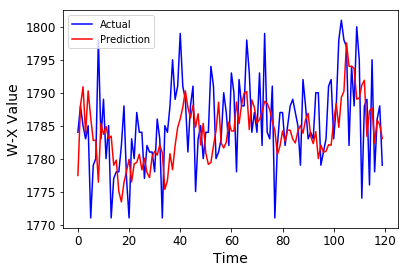

In [235]:

plt.plot(range(len(Y_test[0][:,0])),Y_test[0][:,0], color ='b', label ="Actual")

plt.plot(range(len(X_test[0][:,0])),y_pred[0][:,0], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-X Value")

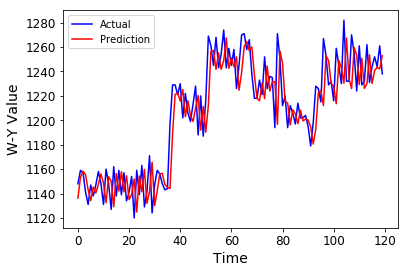

In [236]:


plt.plot(range(len(Y_test[1][:,1])),Y_test[1][:,1], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,1])),y_pred[1][:,1], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Y Value")

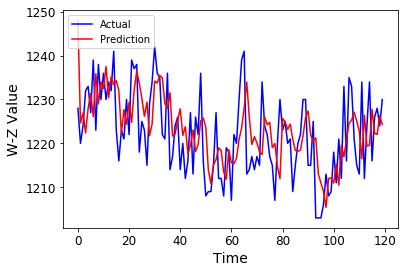

In [237]:

plt.plot(range(len(Y_test[1][:,2])),Y_test[1][:,2], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,2])),y_pred[1][:,2], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Z Value")



In [238]:

plt.plot(range(len(Y_xbar_test[0][:,0])),Y_xbar_test[0][:,0], color ='b', label ="Actual")

plt.plot(range(len(X_xbar_test[0][:,0])),y_xbar_pred[0][:,0], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-X Value")